In [1]:
from sklearn.datasets import load_diabetes
import pandas as pd
import numpy as np
import math

from sklearn.linear_model import LinearRegression
import matplotlib.pyplot as plt
from qiskit import Aer, QuantumCircuit
from qiskit.utils import QuantumInstance, algorithm_globals
from qiskit.circuit import Parameter
from qiskit_machine_learning.neural_networks import TwoLayerQNN
from qiskit_machine_learning.exceptions import QiskitMachineLearningError
from qiskit_machine_learning.algorithms.regressors import NeuralNetworkRegressor, VQR, QSVR
from qiskit.algorithms.optimizers import COBYLA, L_BFGS_B
from IPython.display import clear_output
#from qiskit.opflow.gradients import Gradient
from qiskit_machine_learning.kernels import QuantumKernel
#from qiskit.circuit.library import RealAmplitudes, EfficientSU2, ZZFeatureMap, PauliFeatureMap, ZFeatureMap

import time
import warnings
warnings.filterwarnings('ignore')

%matplotlib inline

plt.rcParams['figure.figsize'] = [10, 7]
%config InlineBackend.figure_format = 'retina'

algorithm_globals.random_seed = 42

In [2]:
fano_data = pd.read_csv("./datasets/signal_080_peak_1_fano_adjust.csv")

In [3]:
fano_data.head()

,# signal_id,signal_original_x,signal_original_y,signal_fano_y,peak_xcoord,peak_ycoord,w,A,y0,xc,q,b_field
0,81.0,4.199235e+09,-0.000500,-0.000696,4.198820e+09,0.003299,1.601944e+06,0.003258,-0.000791,4.206137e+09,3.385428,-0.024
1,81.0,4.199248e+09,-0.000501,-0.000696,4.198820e+09,0.003299,1.601944e+06,0.003258,-0.000791,4.206137e+09,3.385428,-0.024
2,81.0,4.199261e+09,-0.000502,-0.000697,4.198820e+09,0.003299,1.601944e+06,0.003258,-0.000791,4.206137e+09,3.385428,-0.024
3,81.0,4.199274e+09,-0.000503,-0.000697,4.198820e+09,0.003299,1.601944e+06,0.003258,-0.000791,4.206137e+09,3.385428,-0.024
4,81.0,4.199287e+09,-0.000504,-0.000697,4.198820e+09,0.003299,1.601944e+06,0.003258,-0.000791,4.206137e+09,3.385428,-0.024


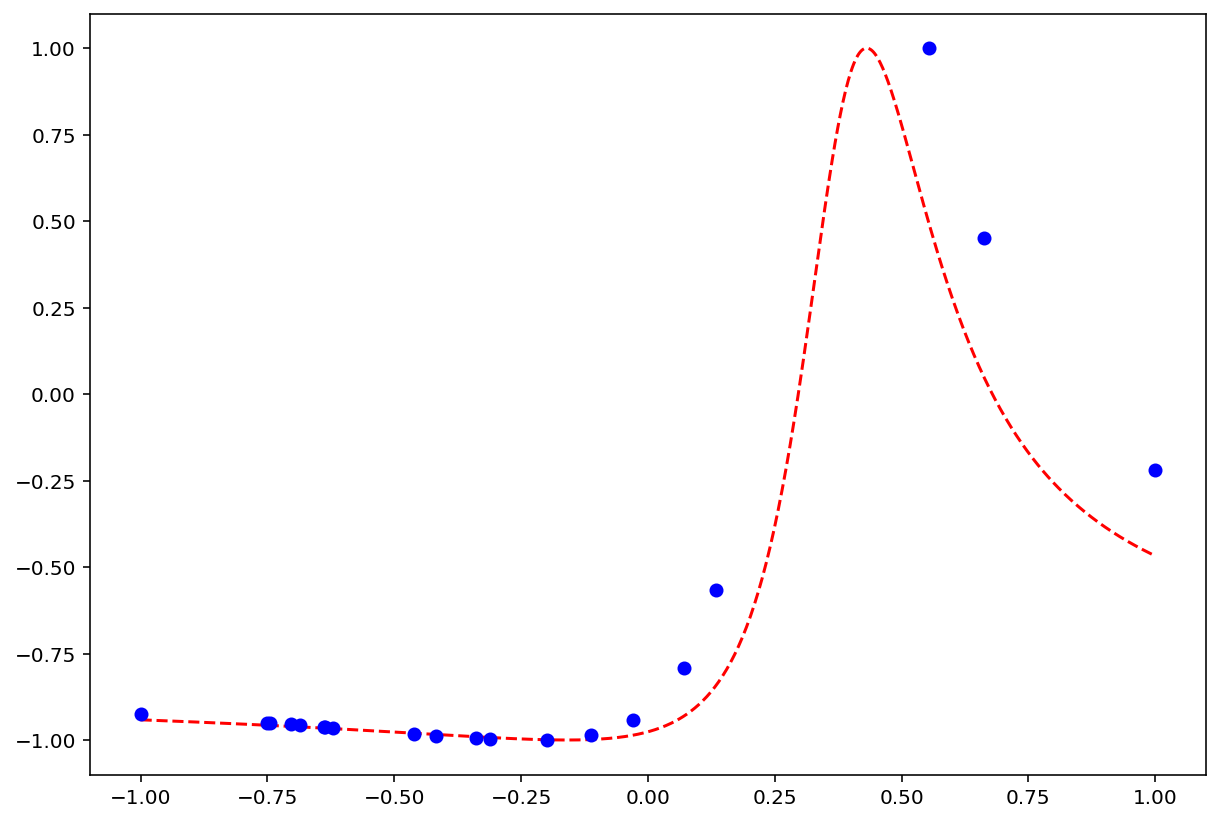

In [24]:
num_samples = 20
#eps = 0.01
#lb, ub = -np.pi, np.pi

y0 = fano_data["y0"].values[0]
A = fano_data["A"].values[0]
xc = fano_data["xc"].values[0]
q = fano_data["q"].values[0]
w = fano_data["w"].values[0]

def func_fano(x, xc, w, q, y0):
    y = y0+A*(2*(x-xc)/w+q)*(2*(x-xc)/w+q)/(2*(x-xc)/w*2*(x-xc)/w+1)/(1+q*q)
    return y

f = lambda x: func_fano(x, xc, w, q, y0)

X_ = fano_data["signal_original_x"].values.reshape(-1,1)
y_ = f(X_)

#y_ = fano_data["signal_original_y"].values


X = np.random.choice(X_[:,0], size=num_samples).reshape(-1,1)

#X = (ub - lb) * np.random.choice(X_[:,0], size=num_samples).reshape(-1,1) + lb
#y = f(X[:, 0]) + eps * (2 * np.random.uniform(lb, ub, num_samples) + ub)

#X = (ub - lb) * algorithm_globals.random.random([num_samples, 1]) + lb
#y = f(X[:, 0])# + eps * (2 * algorithm_globals.random.random(num_samples) - 1)

#X = (ub - lb) * algorithm_globals.random.random([num_samples, 1]) + lb
#y = f(X[:, 0]) + eps * (2* np.random.choice(X_[:,0], size=num_samples)  - 1)

y = f(X[:, 0]) #+ (np.random.choice(X_[:,0], size=num_samples))

def scale(arr, lvalue = -1, rvalue = 1):
    return np.interp(arr, (arr.min(), arr.max()), (lvalue, rvalue))
    
X = scale(X)
y = scale(y)

X_ = scale(X_)
y_ = scale(y_)

plt.plot(X_, y_, "r--")
plt.plot(X, y, "bo")
plt.show()

In [25]:
lm = LinearRegression()
lm.fit(X, y)

LinearRegression()

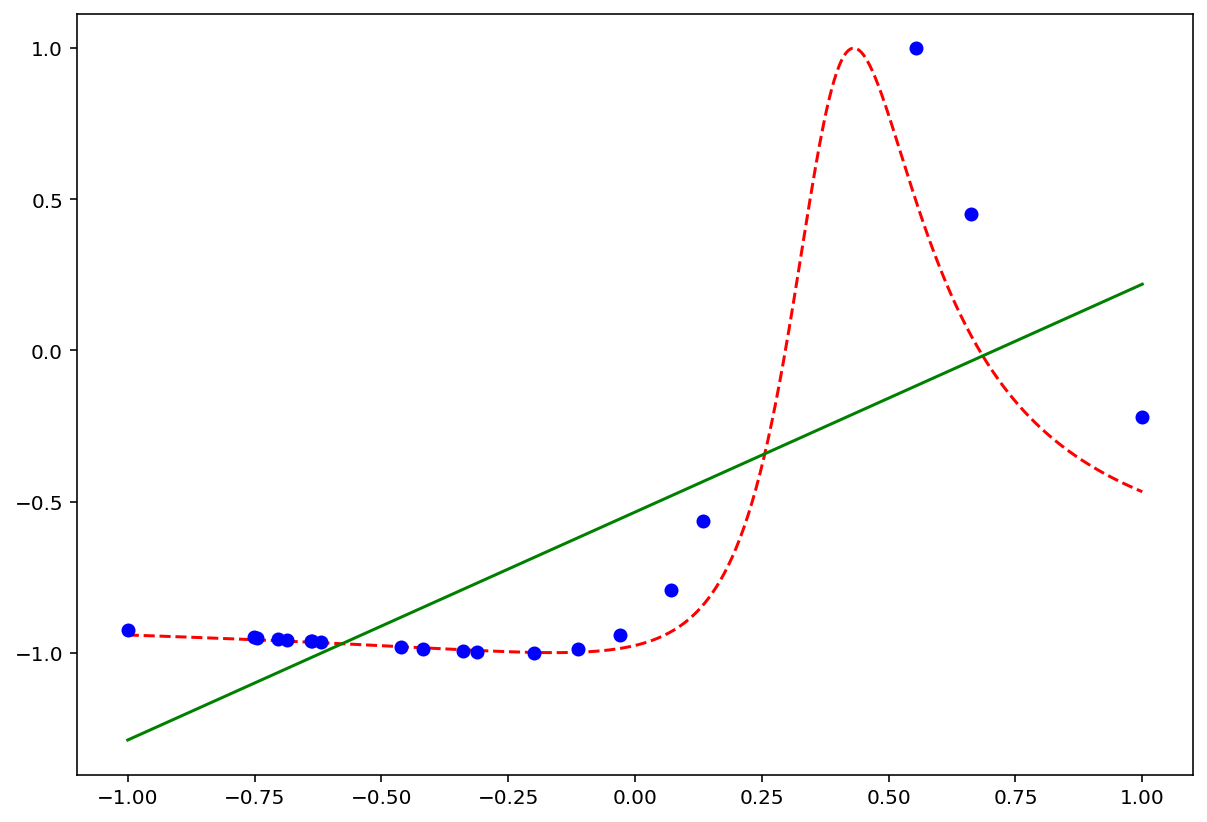

In [26]:
# plot target function
plt.plot(X_, y_, "r--")

# plot data
plt.plot(X, y, "bo")

# plot fitted line
y_predict = lm.predict(X_)
plt.plot(X_, y_predict, "g-")
plt.show()

In [27]:
quantum_instance = QuantumInstance(Aer.get_backend("aer_simulator"), shots=1024)

In [28]:
# construct simple feature map
param_x = Parameter("x")
feature_map = QuantumCircuit(1, name="fm")
feature_map.ry(param_x, 0)

# construct simple ansatz
param_y = Parameter("y")
ansatz = QuantumCircuit(1, name="vf")
ansatz.ry(param_y, 0)

# construct QNN
regression_opflow_qnn = TwoLayerQNN(1, feature_map, ansatz, quantum_instance=quantum_instance)

In [29]:
def callback_graph(weights, obj_func_eval):
    clear_output(wait=True)
    objective_func_vals.append(obj_func_eval)
    plt.title("Objective function value against iteration")
    plt.xlabel("Iteration")
    plt.ylabel("Objective function value")
    plt.plot(range(len(objective_func_vals)), objective_func_vals)
    plt.show()

In [30]:
# construct the regressor from the neural network
regressor = NeuralNetworkRegressor(
    neural_network=regression_opflow_qnn,
    loss="squared_error",
    #optimizer=L_BFGS_B(),
    optimizer=COBYLA(400),
    callback=callback_graph,
)

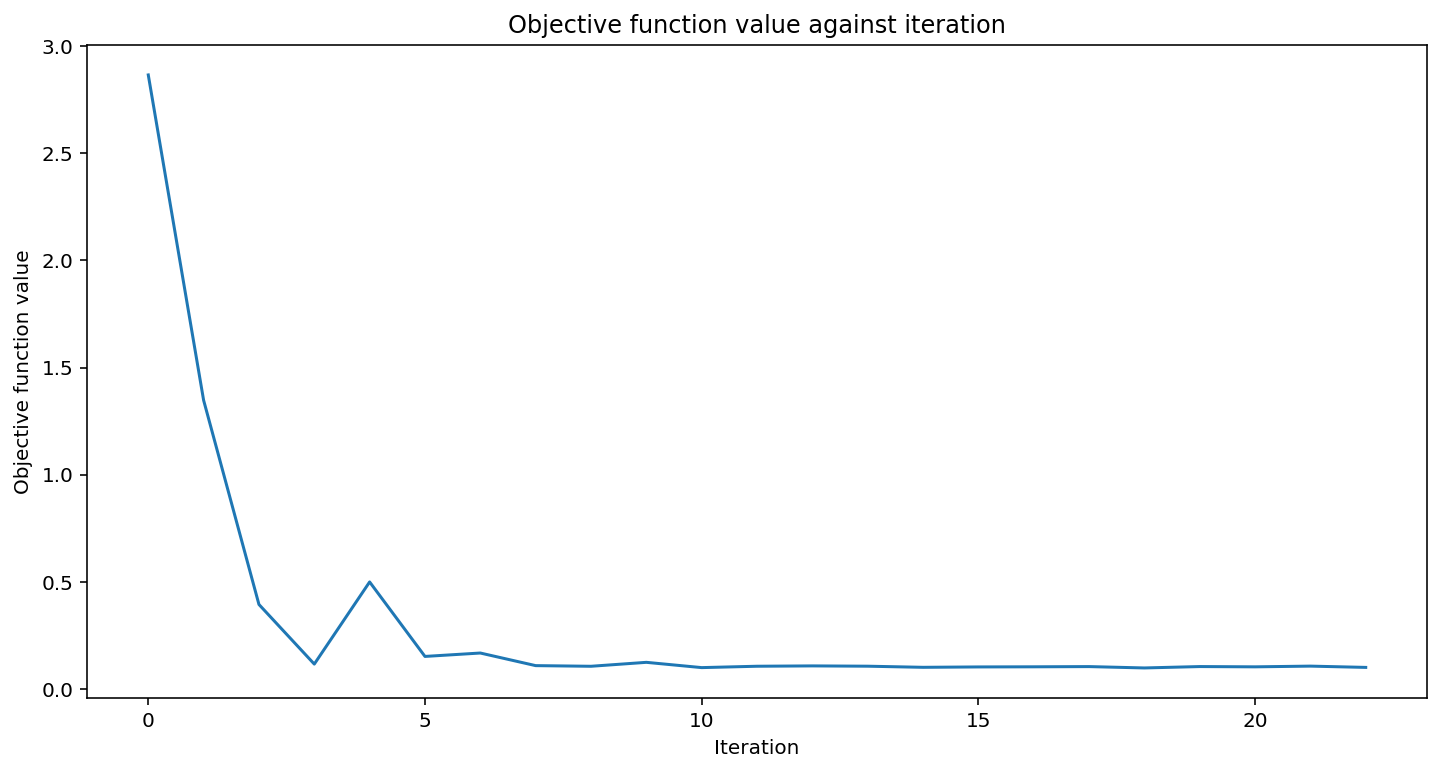

0.617663721328721

In [31]:
# create empty array for callback to store evaluations of the objective function
objective_func_vals = []
plt.rcParams["figure.figsize"] = (12, 6)

# fit to data
regressor.fit(X, y)

# return to default figsize
plt.rcParams['figure.figsize'] = [10, 7]

# score the result
regressor.score(X, y)

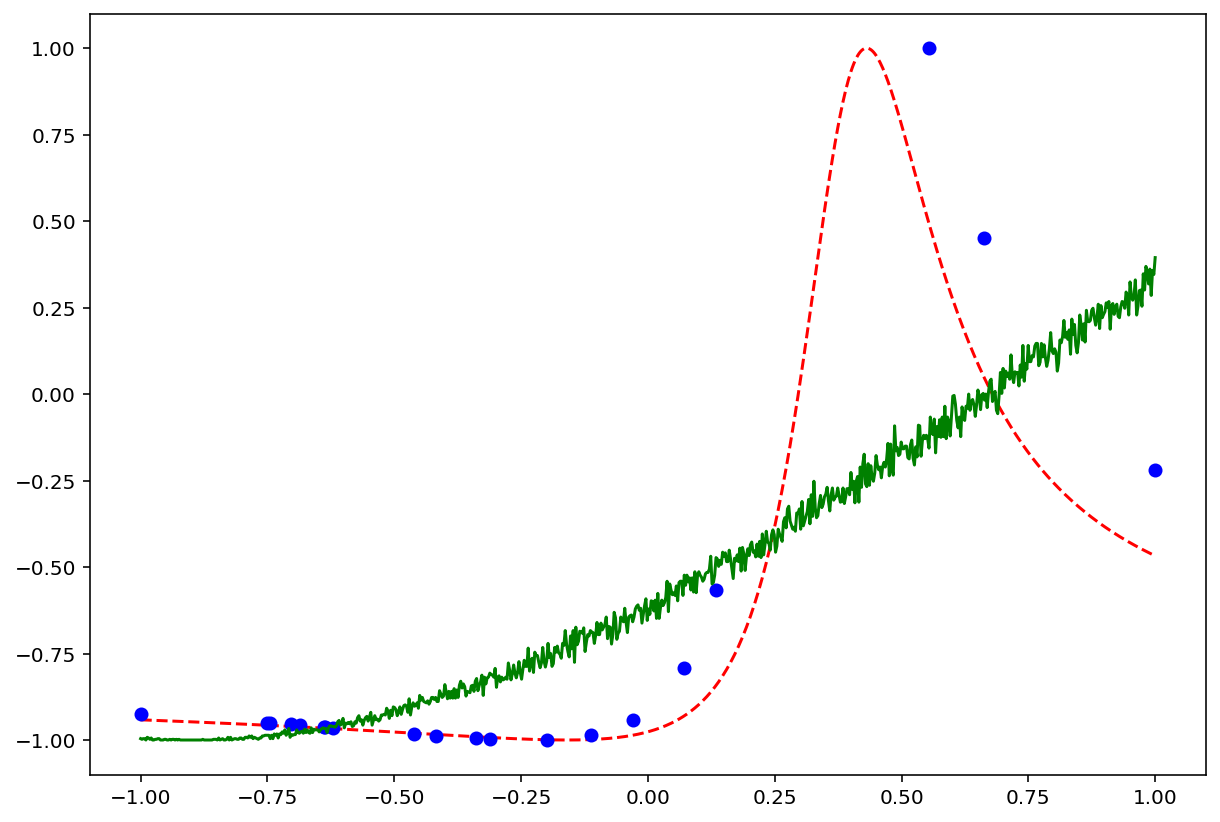

In [32]:
# plot target function
plt.plot(X_, y_, "r--")

# plot data
plt.plot(X, y, "bo")

# plot fitted line
y_predict = regressor.predict(X_)
plt.plot(X_, y_predict, "g-")
plt.show()

In [33]:
X_.shape

(768, 1)

In [34]:
vqr = VQR(
    feature_map=feature_map,
    ansatz=ansatz,
    optimizer=L_BFGS_B(),
    quantum_instance=quantum_instance,
    callback=callback_graph,
)

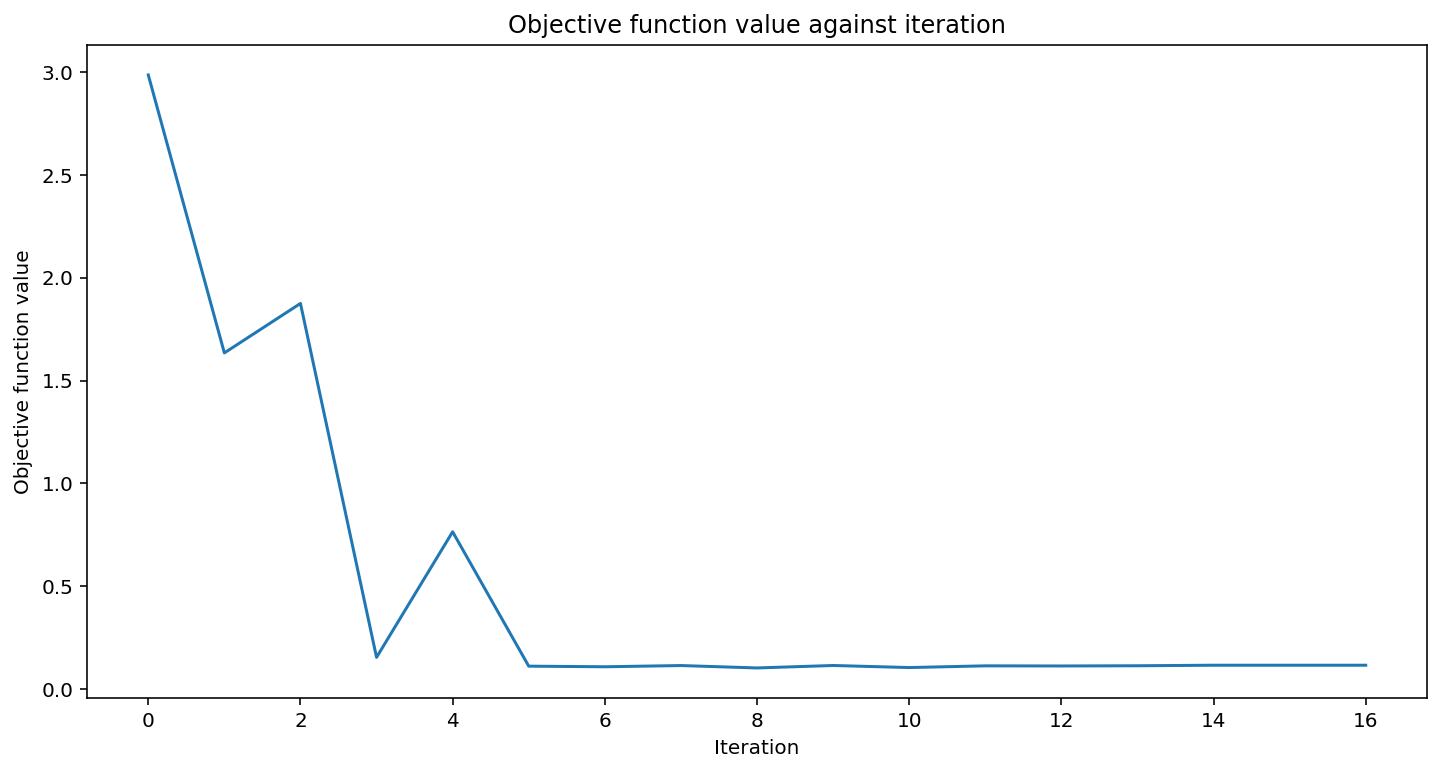

0.5909720472121867

In [35]:
# create empty array for callback to store evaluations of the objective function
objective_func_vals = []
plt.rcParams["figure.figsize"] = (12, 6)

# fit regressor
vqr.fit(X, y)

# return to default figsize
plt.rcParams['figure.figsize'] = [10, 7]

# score result
vqr.score(X, y)

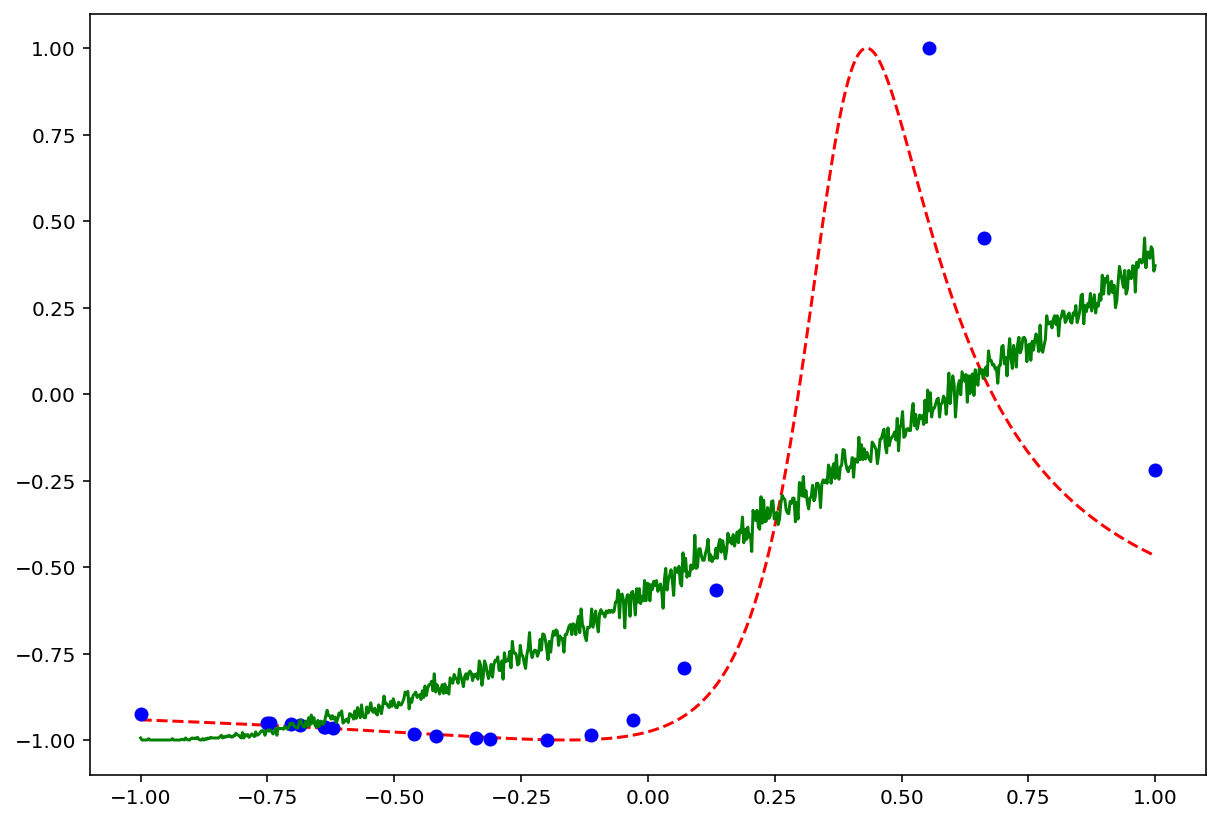

In [36]:
plt.rcParams['figure.figsize'] = [10, 7]

# plot target function
plt.plot(X_, y_, "r--")

# plot data
plt.plot(X, y, "bo")

# plot fitted line
y_predict = vqr.predict(X_)
plt.plot(X_, y_predict, "g-")
plt.show()

## Quantum Support Vector Regressor

In [37]:
qkernel = QuantumKernel(feature_map=feature_map, quantum_instance=quantum_instance)

qsvr = QSVR(quantum_kernel=qkernel)
qsvr.fit(X, y)

QSVR(C=1.0, cache_size=200, coef0=0.0, degree=3, epsilon=0.1, gamma='scale',
     max_iter=-1,
     quantum_kernel=<qiskit_machine_learning.kernels.quantum_kernel.QuantumKernel object at 0x0000029D41E3C108>,
     shrinking=True, tol=0.001, verbose=False)

In [ ]:
plt.rcParams['figure.figsize'] = [10, 7]

# plot target function
plt.plot(X_, y_, "r--")

# plot data
plt.plot(X, y, "bo")

# plot fitted line
y_predict = qsvr.predict(X_)
plt.plot(X_, y_predict, "g-")
plt.show()